In [2]:
import rvnewop as rv
from glob import glob
import matplotlib.pyplot as plt
from itertools import accumulate

Processing ./embench_hst/aha-mont64.hst...


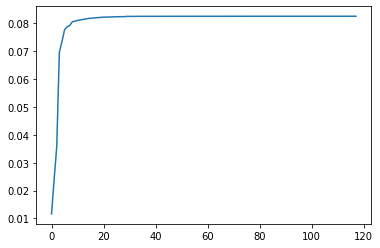

Saved 1155232 cycles out of 14000863 (8.251%) with 118 new instructions
max depth: 5
max mult depth: 0
Processing ./embench_hst/ud.hst...


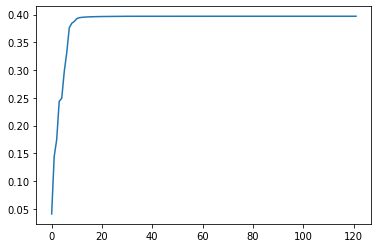

Saved 3736310 cycles out of 9409430 (39.71%) with 122 new instructions
max depth: 5
max mult depth: 0
Processing ./embench_hst/st.hst...
ERROR decoding: 2398
ERROR decoding: 239c
ERROR decoding: a39c
ERROR decoding: 2398
ERROR decoding: a39c
ERROR decoding: 2398
ERROR decoding: a39c
ERROR decoding: 239c
ERROR decoding: a39c
ERROR decoding: 2398
ERROR decoding: 2394
ERROR decoding: 2398
ERROR decoding: 2398
ERROR decoding: a39c


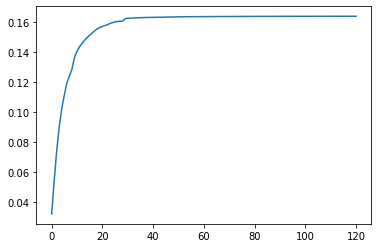

Saved 114365 cycles out of 697660 (16.39%) with 121 new instructions
max depth: 6
max mult depth: 7
Processing ./embench_hst/edn.hst...


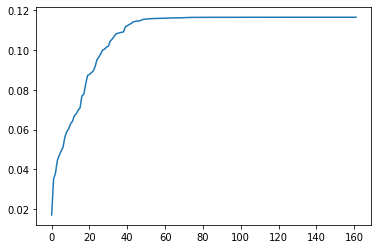

Saved 1507054 cycles out of 12934736 (11.65%) with 162 new instructions
max depth: 8
max mult depth: 0
Processing ./embench_hst/minver.hst...
ERROR decoding: 6398
ERROR decoding: 639c
ERROR decoding: e39c
ERROR decoding: 639c
ERROR decoding: 639c
ERROR decoding: 639c
ERROR decoding: 639c
ERROR decoding: e39c
ERROR decoding: e39c
ERROR decoding: 6398
ERROR decoding: e39c
ERROR decoding: 639c
ERROR decoding: 6398
ERROR decoding: 6394
ERROR decoding: e39c
ERROR decoding: e39c
ERROR decoding: e39c
ERROR decoding: 639c
ERROR decoding: 639c
ERROR decoding: e39c
ERROR decoding: e39c
ERROR decoding: 6398
ERROR decoding: 639c
ERROR decoding: 6398
ERROR decoding: 639c


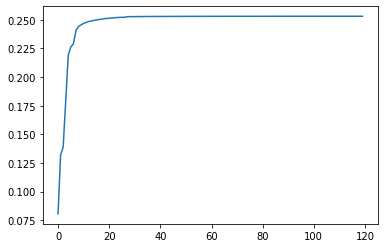

Saved 584007 cycles out of 2307519 (25.31%) with 120 new instructions
max depth: 5
max mult depth: 0
Processing ./embench_hst/slre.hst...


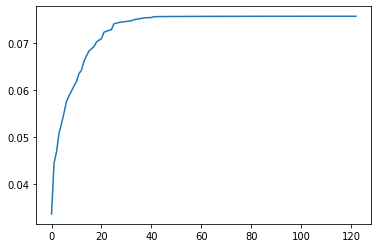

Saved 485957 cycles out of 6412800 (7.578%) with 123 new instructions
max depth: 5
max mult depth: 0
Processing ./embench_hst/qrduino.hst...


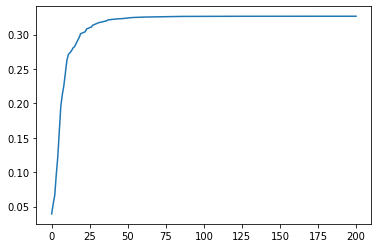

Saved 2645908 cycles out of 8100040 (32.67%) with 201 new instructions
max depth: 7
max mult depth: 0
Processing ./embench_hst/cubic.hst...
ERROR decoding: 2398
ERROR decoding: 239c
ERROR decoding: 2798
ERROR decoding: 279c
ERROR decoding: 2b98
ERROR decoding: 2b9c
ERROR decoding: a39c
ERROR decoding: a09c
ERROR decoding: a09c
ERROR decoding: a39c
ERROR decoding: 239c
ERROR decoding: 239c
ERROR decoding: a39c
ERROR decoding: 239c
ERROR decoding: a39c
ERROR decoding: 239c
ERROR decoding: a39c


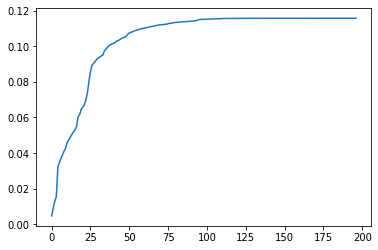

Saved 1004256 cycles out of 8680729 (11.57%) with 197 new instructions
max depth: 5
max mult depth: 2
Processing ./embench_hst/matmult-int.hst...


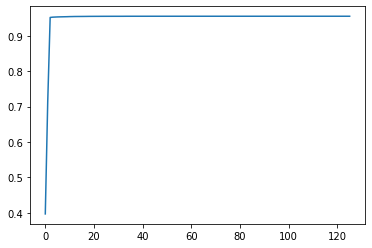

Saved 18339450 cycles out of 19196666 (95.53%) with 126 new instructions
max depth: 6
max mult depth: 7
Processing ./embench_hst/picojpeg.hst...


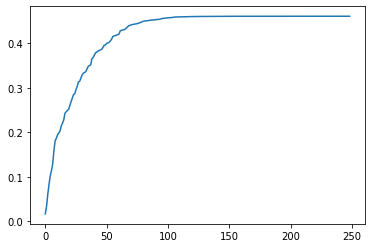

Saved 6121880 cycles out of 13284021 (46.08%) with 249 new instructions
max depth: 11
max mult depth: 0
Processing ./embench_hst/sglib-combined.hst...


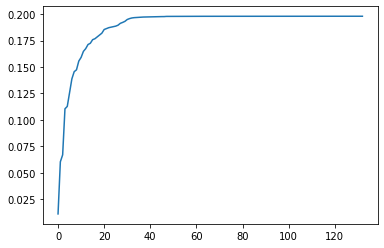

Saved 1365174 cycles out of 6895383 (19.8%) with 133 new instructions
max depth: 5
max mult depth: 2
Processing ./embench_hst/wikisort.hst...
ERROR decoding: a39c
ERROR decoding: 239c


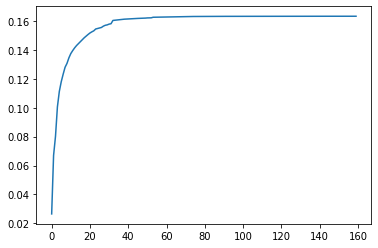

Saved 488627 cycles out of 2990776 (16.34%) with 160 new instructions
max depth: 8
max mult depth: 0
Processing ./embench_hst/nbody.hst...
ERROR decoding: 2398
ERROR decoding: 2394
ERROR decoding: 3f9c
ERROR decoding: a39c
ERROR decoding: 3f98
ERROR decoding: 3394
ERROR decoding: 339c
ERROR decoding: 3790
ERROR decoding: 379c
ERROR decoding: 3b90
ERROR decoding: 3b9c
ERROR decoding: 2398
ERROR decoding: 239c
ERROR decoding: 3f98
ERROR decoding: 3f9c
ERROR decoding: 2398
ERROR decoding: 239c
ERROR decoding: 2398
ERROR decoding: 239c
ERROR decoding: 3f98
ERROR decoding: 3f9c


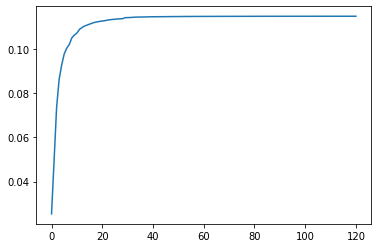

Saved 274527 cycles out of 2387761 (11.5%) with 121 new instructions
max depth: 5
max mult depth: 0
Processing ./embench_hst/nsichneu.hst...


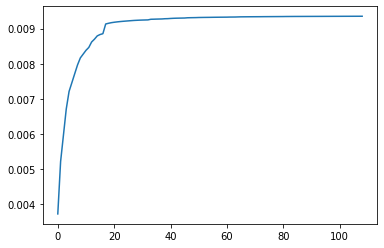

Saved 39112 cycles out of 4182080 (0.9352%) with 109 new instructions
max depth: 5
max mult depth: 0
Processing ./embench_hst/nettle-sha256.hst...


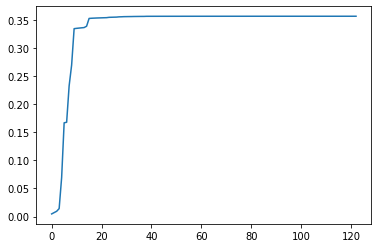

Saved 2346582 cycles out of 6565772 (35.74%) with 123 new instructions
max depth: 5
max mult depth: 0
Processing ./embench_hst/huffbench.hst...


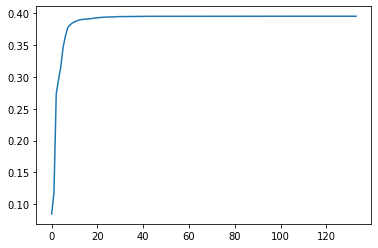

Saved 3220092 cycles out of 8149586 (39.51%) with 134 new instructions
max depth: 5
max mult depth: 0
Processing ./embench_hst/crc32.hst...


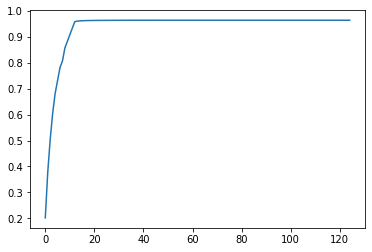

Saved 6692934 cycles out of 6943406 (96.39%) with 125 new instructions
max depth: 6
max mult depth: 0
Processing ./embench_hst/nettle-aes.hst...


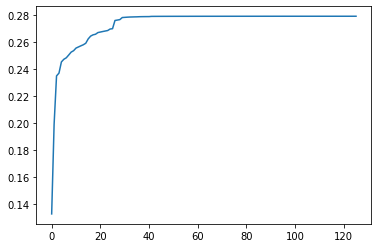

Saved 2213074 cycles out of 7926990 (27.92%) with 126 new instructions
max depth: 5
max mult depth: 0
Processing ./embench_hst/statemate.hst...


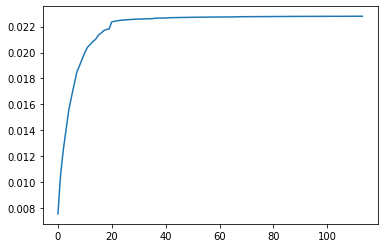

Saved 46782 cycles out of 2052178 (2.28%) with 114 new instructions
max depth: 5
max mult depth: 0


In [3]:
%matplotlib inline
for FILENAME in glob("./embench_hst/*.hst"):
    print("Processing {}...".format(FILENAME))

    prog = rv.Histogram.parse(FILENAME, isa="32ICM")
    prog.findBasicBlocks()

    prog.addLivenessValuesToGraph()

    # total cycles = sum of all the frequencies
    total_cycles = sum(
        [inst.freq for bb in prog.basicBlocks for inst in bb.bbInstructions()]
    )

    new_instructions = []

    for i, b in enumerate((prog.getSubBlocks())):
        graph = b.constructDAG()

        # temp will store every permutation of candidate subgraphs
        temp = []
        for n in rv.analysis.findCandidateSubgraphs(prog, graph):
            subtree = rv.analysis.createSubtreeFromNode(graph, n)
            root = n

            temp.append(rv.Subgraph(subtree, root))

        # add candidate subgraph with highest score to new instructions list
        current_nodes = set()
        temp = sorted(temp, key=lambda sg: sg.score, reverse=True)
        while temp:
            if any([(n in current_nodes) for n in temp[0].graph.nodes]):
                temp.pop(0)
            else:
                new_instructions.append(temp.pop(0))

    new_instructions = sorted(new_instructions, key=lambda sg: sg.score, reverse=True)

    inst_dict = {}
    for subgraph in new_instructions:
        key = rv.analysis.graphToParenString(subgraph.graph)

        if key in inst_dict:
            inst_dict[key].score += subgraph.score
        else:
            inst_dict[key] = subgraph

    new_instructions = [inst_dict[key] for key in inst_dict]

    max_depth = 0
    max_mult_depth = 0
    for sg in new_instructions:
        if sg.containsMultiplyInstruction():
            max_mult_depth = max(max_mult_depth, sg.depth)
        else:
            max_depth = max(max_depth, sg.depth)

    saved_cycles = sum([sg.score for sg in new_instructions])
    percent_cycles = float(saved_cycles) / total_cycles * 100
    plt.clf()
    plt.plot([x for x in range(len(new_instructions))],list(map(lambda x:x/total_cycles, accumulate([sg.score for sg in new_instructions]))))
    plt.show()
    print(
        """Saved {} cycles out of {} ({:.4}%) with {} new instructions""".format(
            saved_cycles, total_cycles, percent_cycles, len(new_instructions)
        )
    )
    print("max depth: {}\nmax mult depth: {}".format(max_depth, max_mult_depth))
